In [ ]:
from google.colab import drive
import os
from tqdm import tqdm
import numpy as np

from datetime import datetime
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/binance-bdlob
!pip install -e .
from bilob.model.dataset import TimeSeriesDataset, WindowData
from bilob.model.bdlob_model import BayesianDeepLOB

import torch
import torch.nn as nn

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/binance-bdlob
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/binance-bdlob
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attemp

In [ ]:
weight_dir = '/content/drive/MyDrive/model_weights'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

data_local_directory, data_s3_directory = '/content/drive/MyDrive/original_data', '/content/drive/MyDrive/original_data/s3'
weight_dir = '/content/drive/MyDrive/model_weights'
list_data_files = os.listdir(data_local_directory) + [os.path.join('s3/', x) for x in os.listdir(data_s3_directory)]
list_data_files = [data_file for data_file in list_data_files if 'BTC' in data_file]
print(f'{len(list_data_files)} files loading')

list_data = []
for file_each in tqdm(list_data_files):
    list_data.append(np.loadtxt(os.path.join(data_local_directory, file_each)))

window_data = WindowData(*list_data)
train_data, valid_data, test_data = window_data.divide_dataset(train=60, valid=20, test=20)
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(valid_data)
test_dataset = TimeSeriesDataset(test_data)

Using device: cuda
2679 files loading


100%|██████████| 2679/2679 [19:32<00:00,  2.29it/s]


In [ ]:
import warnings
import bisect
import inspect
import torch
from torch.utils import data
import numpy as np

class WindowData:
    """
    Manage each sequence to retrieve valid data in window
    """
    def __init__(self, *args):
        """
        Args:
            args: instance of (np.array, torch.Tensor) with dimension (159, -1)
        """

        self.sequences = []
        self.sequence_boundaries = [0]
        cumulative_length = 0

        for arg in args:
            if not isinstance(arg, (np.ndarray, torch.Tensor)):
                raise ValueError(f"Argument {arg} is not an array({type(arg)}")
            if arg.shape[0] != 159:
                raise ValueError(f"Array must have 159 rows, but got {arg.shape[0]}.")
            if not isinstance(arg, torch.Tensor):
                arg = torch.from_numpy(arg)

            cumulative_length += arg.shape[1]

            self.sequences.append(arg)
            self.sequence_boundaries.append(cumulative_length)


    def __len__(self):
        return len(self.sequences)


    def get_trimmed_index(self, left, right):
        """
        Return index to use in dataloader which trimmed each side used
        calculation but don't have smoothed average(left) or
        prediction horizon(right)

        Args:
            left, right: trimming length
        """
        indices = []
        for i in range(len(self.sequences)):
            start = self.sequence_boundaries[i] + left
            end = self.sequence_boundaries[i+1] - right
            if start < end:
                indices.extend(range(start, end))
        return indices


    def get_sequence_index(self, index):
        """
        Return index of sequence that includes the (global) index
        """
        return bisect.bisect_right(self.sequence_boundaries, index) - 1


    def _get_inner_index(self, index, seq_idx):
        return index - self.sequence_boundaries[seq_idx]


    def get_window_sequence(self, seq_idx, inner_index, left, right):
        """
        Return sequence with indicated window size using sequence index

        Args:
            seq_idx: sequence index
            inner_index: sequence element index
            left, right: window length
        """
        sequence = self.sequences[seq_idx]
        if (inner_index-left < 0) or (inner_index+right > sequence.shape[1]):
            raise ValueError(f"Window is larger than available size.")
        return sequence[:, inner_index-left:inner_index+right]


    def get_data_window(self, index, left, right):
        """
        Return sequence with indicated window size using global index

        Args:
            index: global index(element of trimmed index)
            left, right: window length
        """
        seq_idx = self.get_sequence_index(index)
        inner_index = self._get_inner_index(index, seq_idx)
        return self.get_window_sequence(seq_idx, inner_index, left, right)


    def divide_dataset(self, train=60, valid=20, test=20):
        """
        Divide data into train, valid, test set
        Args:
            train, valid, test: percentage of each
        """
        if (train + valid + test) != 100:
            raise ValueError(f"Each size is not valid: train + valid + test = {train} + {valid} + {test} = {test+valid+test}")
        data_size = self.get_data_size()
        last_train = (data_size*train)//100
        last_valid = (data_size*(train+valid))//100

        last_sequence_train = self._get_sequence_number_from_index(last_train)
        last_sequence_valid = self._get_sequence_number_from_index(last_valid)

        if (last_sequence_train == last_sequence_valid) or (last_sequence_valid == len(self)-1):
            raise RuntimeError("Data sequence sizes are not sufficient to divide(too large)")
        return WindowData(*self.sequences[:last_sequence_train]), WindowData(*self.sequences[last_sequence_train:last_sequence_valid]), WindowData(*self.sequences[last_sequence_valid:])


    def get_data_size(self):
        """
        Return total size of the data
        """
        total = 0
        for sequence in self.sequences:
            total+=sequence.shape[1]
        return total


    def _get_sequence_number_from_index(self, index):
        cursor = 0
        number = 0
        for sequence in self.sequences:
            cursor += sequence.shape[1]
            if index < cursor:
               return number
            number +=1


class TimeSeriesDataset(data.Dataset):
    """
    A PyTorch Dataset for times series data with support for multiple sequences,
    customizable time steps, and prediction horizons

    Store information about the available data to retrieve a valid sequence
    """
    def __init__(self, data, prediction_horizon=100, time_steps=100, level = 10, step=1, skip = 1, change=0.0001, num_classes=3, smoothing="exponential_sqrt_range", use_difference=True):
        """
        Args:
            data: Input times series data
            prediction_horizon: Number of steps ahead to predict
            time_steps: Number of time steps used for prediction
            level: Feature level limit
            step: Step size for sampling time steps
            skip: Skip between consecutive samples
            change: change of ratio to divide label class
            num_classes: number of label classes
            smoothing: exponential, linear, uniform
        """

        self.prediction_horizon = prediction_horizon
        self.time_steps = time_steps
        self.skip = skip
        self.step = step
        self.level = level
        self.change = change
        self.num_classes = num_classes

        self.smoothing = smoothing

        self.use_difference = use_difference

        self._data_arrange(data)
        self._process_criteria()
        self._process_index()

        self._precompute_smoothing_weights()
        self._precompute_smoothed_prices()


    def change_properties(self, **kwargs):
        """Manage properties changes to process the inner index"""
        for key, value in kwargs.items():
            if key == 'smoothing':
                self.smoothing = value
                self._precompute_smoothing_weights()
            else:
                setattr(self, key, value)
        self._process_criteria()
        self._precompute_smoothed_prices()
        self._precompute_smoothing_weights()

        self._process_index()


    def __len__(self):
        """Denotes the total number of samples"""
        return len(self._index_data)


    def __getitem__(self,index):
        x, y, *_ = self._getitems(index)

        return x, y


    def _precompute_smoothing_weights(self):
        size = self.time_steps
        if self.smoothing == 'exponential':
            weights = torch.exp(torch.linspace(0, np.sqrt(size), size))
            self._smooth_weights = weights/torch.sum(weights)
        elif self.smoothing == 'linear':
            weights = torch.linspace(0, 1, size)
            self._smooth_weights = weights/torch.sum(weights)
        elif self.smoothing == 'uniform':
            self._smooth_weights = torch.ones(size)/size
        elif self.smoothing == 'exponential_sqrt_range':
            sqrt_size = int(size**0.5)
            weights = torch.zeros(size)
            weights[-sqrt_size:] = torch.exp(torch.linspace(0, sqrt_size, sqrt_size))

            self._smooth_weights = weights/torch.sum(weights)
        else:
            raise ValueError(f"'{smoothing} is not defined")
        self._smooth_weights = torch.flip(self._smooth_weights, [0])

    def _smoothing(self, x):
        return torch.sum(x * self._smooth_weights, dim=1)


    def _precompute_smoothed_prices(self):
        self.smoothed_prices = []
        self.labels = []
        for sequence in self.data.sequences:
            if sequence.shape[1] < self.time_steps:
                smoothed_price = np.zeros_like(sequence[0,:])
                percentage_change = np.zeros_like(smoothed_price)
            else:
                best_prices = sequence[:4:2,:].numpy()
                mean_price = np.mean(best_prices, axis=0)
                smoothed_price = np.zeros_like(sequence[0,:])
                smoothed_price[self.time_steps-1:] = np.convolve(mean_price, self._smooth_weights, mode='valid')
                smoothed_price_k = np.roll(smoothed_price, -self.time_steps)
                with warnings.catch_warnings(action="ignore"):
                    percentage_change = (smoothed_price_k - smoothed_price)/smoothed_price

            self.smoothed_prices.append(torch.from_numpy(smoothed_price))
            self.labels.append(np.digitize(percentage_change, self.criteria))
        self.smoothed_prices = np.concatenate(self.smoothed_prices)
        self.labels = np.concatenate(self.labels)


    def _data_arrange(self, data):
        if data is None:
            self.data = None
            return
        elif isinstance(data, list):
            self.data = WindowData(*data)
        elif isinstance(data, (np.ndarray, torch.Tensor)):
            self.data = WindowData(data)
        elif isinstance(data, WindowData):
            self.data = data
        else:
            raise ValueError(f"Can't process data type: {type(data)}")


    def _process_index(self):
        """
        Process available index that mapping the real data index
        """
        self._index_data = self.data.get_trimmed_index(self.time_steps, self.prediction_horizon)[::self.skip]


    def _process_criteria(self):
        self.criteria = torch.linspace(-self.change*(self.num_classes//2), self.change*(self.num_classes//2),self.num_classes-1)





    def _getitems(self, indices, test=False):
        """Process multiple items at once for batch efficiency"""
        if isinstance(indices, int):
            real_indices = [self._index_data[indices]]
        else:
            batch_size = len(indices)
            real_indices = [self._index_data[i] for i in indices]


        x_batch = []
        y_batch = []
        if test: sequence_windows = []
        for idx in real_indices:
            x = self.data.get_data_window(idx, self.time_steps, 0)
            y = self.labels[idx]
            if self.use_difference == True:
                mean_last = self.smoothed_prices[idx]
                x = x.clone()
                x[::2,:] -= mean_last
            if test:
                window_item = self.data.get_data_window(idx, self.time_steps, self.prediction_horizon)
                sequence_window = window_item[:self.level*4,:]
                if self.use_difference == True:
                    sequence_window = sequence_window.clone()
                    sequence_window[::2,:]-=mean_last
                sequence_windows.append(sequence_window)

            x_batch.append(x)
            y_batch.append(y)
        x = torch.stack(x_batch)
        x = torch.transpose(x, 1, 2)
        x = x[:,::self.step,:self.level*4]
        y = np.array(y_batch)
        #y = y.squeeze(1)
        if isinstance(indices, int):
            y = y[0]
        if test: return x, y, torch.stack(sequence_windows)
        return x, y
window_data = WindowData(*list_data)
train_data, valid_data, test_data = window_data.divide_dataset(train=60, valid=20, test=20)
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(valid_data)
test_dataset = TimeSeriesDataset(test_data)

In [ ]:
import json
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
# A function to encapsulate the training loop
def batch_gd(model, criteria, optimizer, train_loader, test_loader, epochs, patience, serial = None):
    if serial is None:
        serial = datetime.now().strftime("%m%d_%H%M")
    print()
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    tqdm_epochs = tqdm(range(epochs))
    torch.cuda.empty_cache()
    for it in tqdm_epochs:

        model.train()

        t0 = datetime.now()
        train_loss = []
        i = 0
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criteria(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            i+=1
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        print('test')
        model.eval()
        test_loss = []
        all_targets = []
        all_predictions = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            with torch.no_grad():
                outputs = model(inputs)
            loss = criteria(outputs, targets)
            test_loss.append(loss.item())

            _, predictions = torch.max(outputs, 1)

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

        all_targets = np.concatenate(all_targets)
        all_predictions = np.concatenate(all_predictions)
        _accuracy_score = accuracy_score(all_targets, all_predictions)
        _classification_report = classification_report(all_targets, all_predictions, digits=4)
        _confusion_matrix = confusion_matrix(all_targets, all_predictions)
        print('accuracy_score:', _accuracy_score)
        print(_classification_report)
        print(_confusion_matrix)
        print(f"ratio 1 vs 3 : {_confusion_matrix[0,0]/(_confusion_matrix[2,0]+_confusion_matrix[0,0])}")
        print(f"ratio 3 vs 1 : {_confusion_matrix[2,2]/(_confusion_matrix[0,2]+_confusion_matrix[2,2])}")


        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        print()
        if test_loss < best_test_loss:
            weight_path = os.path.join(weight_dir, f'{model.__class__.__name__}_weights_{serial}.pth')
            torch.save(model, weight_path)
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

        with open(os.path.join(weight_dir, f'results_training_{serial}.csv'), 'w') as f:
            f.write('Epoch,Train Loss,Validation Loss\n')
            for i in range(len(train_losses)):
                f.write(f'{i+1},{train_losses[i]},{test_losses[i]}\n')
        with open(os.path.join(weight_dir, f'metrics_data_{serial}_{it}.json'), 'w') as f:
            json.dump({'accuracy_score': _accuracy_score, 'classification_report': _classification_report, 'confusion_matrix': _confusion_matrix.tolist()}, f)
        # early stop
        if it - best_test_epoch > patience:
            print('early stop')
            break

    return train_losses, test_losses

In [ ]:
class experiment:
    def __init__(self, serial, k, step, skip, epochs, batch_size, learning_rate, patience, zscore_each, timestep, level = 10, divide_data=1, val_skip = 10,criteria_weight = None, criteria = None, device= None, change = 0.2):
        self.serial = serial
        self.k = k
        self.step = step
        self.skip = skip
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.patience = patience
        self.change = change
        if criteria is not None:
            if criteria_weight is not None:
                # These two are exclusive
                raise ValueError("Can't use both criteria and criteria_weight")
            self.criteria = criteria
        else:
            if criteria_weight is None:
                self.criteria_weight = torch.ones(3).to(device)
            else:
                self.criteria_weight = torch.tensor(criteria_weight).to(device)
            self.criteria = nn.CrossEntropyLoss(weight=self.criteria_weight)
        self.weight_path = os.path.join(weight_dir, f'BayesianDeepLOB_weights_{serial}.pth')
        self.zscore_each = zscore_each
        self.timestep = timestep
        self.level = level
        self.divide_data = divide_data
        self.val_skip = val_skip

    def run(self, no_dup = True):
        global list_data_files
        global data_btcs
        global train_loader
        global val_loader
        global test_loader
        k = self.k
        step = self.step
        skip = self.skip
        epochs = self.epochs
        batch_size = self.batch_size
        learning_rate = self.learning_rate
        time_step = self.timestep
        level = self.level
        patience = self.patience
        if not os.path.isfile(self.weight_path):
            train_dataset.change_properties(prediction_horizon=k,
                                            time_steps=time_step,
                                            level=level,
                                            step=step,
                                            skip=skip,
                                            change=self.change,
                                            num_classes=3,
                                            smoothing="exponential")
            val_dataset.change_properties(prediction_horizon=k,
                                            time_steps=time_step,
                                            level=level,
                                            step=step,
                                            skip=self.val_skip,
                                            change=self.change,
                                            num_classes=3,
                                            smoothing="exponential")
            model = BayesianDeepLOB(3, device, self.level)
            model.to(device)
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            train_labels = train_dataset.labels
            train_labels_index = train_dataset._index_data
            train_labels = train_labels[train_labels_index]
            train_labels_frequency = np.bincount(train_labels)
            train_labels_weight = torch.ones(len(train_labels))
            train_labels_weight[train_labels == 0] = 1/train_labels_frequency[0]
            train_labels_weight[train_labels == 1] = 1/train_labels_frequency[1]
            train_labels_weight[train_labels == 2] = 1/train_labels_frequency[2]
            even_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=train_labels_weight, num_samples=len(train_dataset)//self.divide_data, replacement=True)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=even_sampler)

            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256)
            self.train_losses, self.val_losses = batch_gd(model, self.criteria, self.optimizer,
                                                        train_loader, val_loader, epochs=self.epochs, patience=self.patience, serial = self.serial)
            train_loader = None
            val_loader = None
            test_loader = None
        else:
            if no_dup:
                return
            else:
                self.serial = serial + '_dup'
                self.run()


In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))
torch.cuda.empty_cache()


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  46074 KiB |  18292 MiB | 413853 GiB | 413853 GiB |
|       from large pool |  41088 KiB |  18283 MiB | 413755 GiB | 413755 GiB |
|       from small pool |   4986 KiB |     22 MiB |     97 GiB |     97 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  46074 KiB |  18292 MiB | 413853 GiB | 413853 GiB |
|       from large pool |  41088 KiB |  18283 MiB | 413755 GiB |

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
window_data = WindowData(*list_data)
train_data, valid_data, test_data = window_data.divide_dataset(train=80, valid=15, test=5)
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(valid_data)
test_dataset = TimeSeriesDataset(test_data)

step = 1
learning_rate = 0.000001
date = '0412'
change = 0.5
# list_exp = [[f'exp_{date}_{s}s_k_{k}_skip{skip}_{learning_rate}_zscore_each', k, s, skip, 50, 32, learning_rate, 2, True, 500] for k in [400, 200] for skip in [10, 5, 2] for s in [20, 4, 1]]
list_exp = [[f'exp_{date}_{s}s_k_{k}_skip{skip}_{learning_rate}_zscore_each_{20}_{change}', k, s, skip, 200, 32, learning_rate, 10, True, 1800, 20, 100, 50, change] for k in [6000] for skip in [1] for s in [1]]
for exp in list_exp:
    print(exp)
    experiment(*exp).run()

['exp_0412_1s_k_3000_skip1_1e-06_zscore_each_20_0.1', 3000, 1, 1, 200, 32, 1e-06, 10, True, 1800, 20, 100, 50, 0.1]



  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_CUDA_nll_loss_forward)

In [ ]:
val_dataset.change_properties(prediction_horizon=1800,
                                time_steps=600,
                                level=20,
                                step=1,
                                skip=100,
                                change=0.0025,
                                num_classes=3,
                                smoothing="exponential")
y_true = []
for x, y in val_dataset:
    y_true.append(y)
print(val_dataset.criteria*100)
np.bincount(np.array(y_true))

tensor([-0.2500,  0.2500])


array([  467, 25102,   525])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
from torch import Tensor
window_data = WindowData(*list_data)
train_data, valid_data, test_data = window_data.divide_dataset(train=60, valid=20, test=20)
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(valid_data)
test_dataset = TimeSeriesDataset(test_data)

step = 1
learning_rate = 0.000001
date = '0412_custom_criteria_'
# list_exp = [[f'exp_{date}_{s}s_k_{k}_skip{skip}_{learning_rate}_zscore_each', k, s, skip, 50, 32, learning_rate, 2, True, 500] for k in [400, 200] for skip in [10, 5, 2] for s in [20, 4, 1]]

class criteria_custom(nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = "mean") -> None:
        super().__init__(size_average, reduce, reduction)

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        log_phat = F.log_softmax(input, dim=1)

        ce_loss = -log_phat.gather(1, target.unsqueeze(1)).squeeze(1)

        # Create reversed targets (0 ↔ 2)
        reversed_target = 2 - target
        reversed_ce = -log_phat.gather(1, reversed_target.unsqueeze(1)).squeeze(1)

        # Apply custom calculation only to 0/2 classes
        mask = (target == 0) | (target == 2)
        custom_loss = torch.where(mask, 2 * ce_loss - reversed_ce, ce_loss)

        if self.reduction == 'mean':
            return custom_loss.mean()
        elif self.reduction == 'sum':
            return custom_loss.sum()
        return custom_loss
change = 0.0025

criteria = criteria_custom()
time_step = 1000
list_exp = [[f'exp_{date}_{s}s_k_{k}_skip{skip}_{learning_rate}_zscore_each_{20}_criteria_{change}_{time_step}', k, s, skip, 200, 32, learning_rate, 10, True, time_step, 20, 100, 50, None, criteria, device, change] for k in [1800] for skip in [1] for s in [1]]
for exp in list_exp:
    print(exp)
    experiment(*exp).run()

['exp_0412_custom_criteria__1s_k_1800_skip1_1e-06_zscore_each_20_criteria_0.0025_1000', 1800, 1, 1, 200, 32, 1e-06, 10, True, 1000, 20, 100, 50, None, criteria_custom(), device(type='cuda'), 0.0025]



  0%|          | 0/200 [00:00<?, ?it/s]

test


  0%|          | 1/200 [02:10<7:13:05, 130.58s/it]

accuracy_score: 0.6112280425674214
              precision    recall  f1-score   support

           0     0.0689    0.1931    0.1016      1890
           1     0.9628    0.6299    0.7615     47035
           2     0.0733    0.5664    0.1298      1912

    accuracy                         0.6112     50837
   macro avg     0.3683    0.4631    0.3310     50837
weighted avg     0.8961    0.6112    0.7132     50837

[[  365   623   902]
 [ 4626 29625 12784]
 [  307   522  1083]]
ratio 1 vs 3 : 0.5431547619047619
ratio 3 vs 1 : 0.5455919395465995

model saved
Epoch 1/200, Train Loss: 1.0834,           Validation Loss: 1.0485, Duration: 0:02:10.567363, Best Val Epoch: 0
test


  1%|          | 2/200 [04:20<7:09:27, 130.14s/it]

accuracy_score: 0.5247555913999646
              precision    recall  f1-score   support

           0     0.0670    0.2899    0.1089      1890
           1     0.9723    0.5310    0.6869     47035
           2     0.0679    0.6030    0.1221      1912

    accuracy                         0.5248     50837
   macro avg     0.3691    0.4747    0.3060     50837
weighted avg     0.9046    0.5248    0.6442     50837

[[  548   400   942]
 [ 7180 24976 14879]
 [  447   312  1153]]
ratio 1 vs 3 : 0.5507537688442211
ratio 3 vs 1 : 0.5503579952267303

model saved
Epoch 2/200, Train Loss: 1.0668,           Validation Loss: 1.0476, Duration: 0:02:09.815744, Best Val Epoch: 1
test


  2%|▏         | 3/200 [06:30<7:07:22, 130.16s/it]

accuracy_score: 0.5095304600979601
              precision    recall  f1-score   support

           0     0.0674    0.3979    0.1153      1890
           1     0.9767    0.5129    0.6726     47035
           2     0.0686    0.5382    0.1218      1912

    accuracy                         0.5095     50837
   macro avg     0.3709    0.4830    0.3032     50837
weighted avg     0.9088    0.5095    0.6311     50837

[[  752   316   822]
 [ 9773 24122 13140]
 [  624   259  1029]]
ratio 1 vs 3 : 0.5465116279069767
ratio 3 vs 1 : 0.5559157212317666

model saved
Epoch 3/200, Train Loss: 1.0536,           Validation Loss: 1.0342, Duration: 0:02:10.183839, Best Val Epoch: 2
test


  2%|▏         | 4/200 [08:40<7:05:28, 130.25s/it]

accuracy_score: 0.5741094085016818
              precision    recall  f1-score   support

           0     0.0779    0.3646    0.1284      1890
           1     0.9730    0.5846    0.7304     47035
           2     0.0728    0.5230    0.1278      1912

    accuracy                         0.5741     50837
   macro avg     0.3746    0.4907    0.3289     50837
weighted avg     0.9059    0.5741    0.6853     50837

[[  689   422   779]
 [ 7584 27497 11954]
 [  572   340  1000]]
ratio 1 vs 3 : 0.5463917525773195
ratio 3 vs 1 : 0.5621135469364812

model saved
Epoch 4/200, Train Loss: 1.0426,           Validation Loss: 0.9834, Duration: 0:02:10.361331, Best Val Epoch: 3
test


  2%|▎         | 5/200 [10:51<7:03:34, 130.33s/it]

accuracy_score: 0.2667348584692252
              precision    recall  f1-score   support

           0     0.0516    0.5122    0.0938      1890
           1     0.9917    0.2450    0.3929     47035
           2     0.0522    0.5586    0.0955      1912

    accuracy                         0.2667     50837
   macro avg     0.3652    0.4386    0.1941     50837
weighted avg     0.9215    0.2667    0.3706     50837

[[  968    53   869]
 [16991 11524 18520]
 [  801    43  1068]]
ratio 1 vs 3 : 0.5472018089315998
ratio 3 vs 1 : 0.551368094992256

Epoch 5/200, Train Loss: 1.0321,           Validation Loss: 1.1262, Duration: 0:02:10.466170, Best Val Epoch: 3
test


  3%|▎         | 6/200 [13:02<7:02:09, 130.56s/it]

accuracy_score: 0.28632688789661076
              precision    recall  f1-score   support

           0     0.0598    0.4958    0.1068      1890
           1     0.9907    0.2664    0.4199     47035
           2     0.0484    0.5701    0.0892      1912

    accuracy                         0.2863     50837
   macro avg     0.3663    0.4441    0.2053     50837
weighted avg     0.9206    0.2863    0.3958     50837

[[  937    64   889]
 [13957 12529 20549]
 [  768    54  1090]]
ratio 1 vs 3 : 0.5495601173020528
ratio 3 vs 1 : 0.5507832238504295

Epoch 6/200, Train Loss: 1.0197,           Validation Loss: 1.1240, Duration: 0:02:11.006440, Best Val Epoch: 3
test


  4%|▎         | 7/200 [15:13<7:00:20, 130.68s/it]

accuracy_score: 0.27401302201152705
              precision    recall  f1-score   support

           0     0.0554    0.5508    0.1007      1890
           1     0.9921    0.2523    0.4023     47035
           2     0.0509    0.5350    0.0930      1912

    accuracy                         0.2740     50837
   macro avg     0.3662    0.4460    0.1987     50837
weighted avg     0.9219    0.2740    0.3794     50837

[[ 1041    54   795]
 [16899 11866 18270]
 [  849    40  1023]]
ratio 1 vs 3 : 0.5507936507936508
ratio 3 vs 1 : 0.5627062706270627

Epoch 7/200, Train Loss: 1.0138,           Validation Loss: 1.1327, Duration: 0:02:10.901723, Best Val Epoch: 3
test


  4%|▍         | 8/200 [17:23<6:57:23, 130.43s/it]

accuracy_score: 0.4127702264098983
              precision    recall  f1-score   support

           0     0.0669    0.5561    0.1194      1890
           1     0.9856    0.4035    0.5726     47035
           2     0.0601    0.4990    0.1073      1912

    accuracy                         0.4128     50837
   macro avg     0.3709    0.4862    0.2664     50837
weighted avg     0.9167    0.4128    0.5382     50837

[[ 1051   149   690]
 [13828 18979 14228]
 [  830   128   954]]
ratio 1 vs 3 : 0.5587453482190324
ratio 3 vs 1 : 0.5802919708029197

Epoch 8/200, Train Loss: 1.0043,           Validation Loss: 1.0563, Duration: 0:02:09.902003, Best Val Epoch: 3
test


  4%|▍         | 9/200 [19:33<6:55:28, 130.51s/it]

accuracy_score: 0.3061156244467612
              precision    recall  f1-score   support

           0     0.0627    0.5275    0.1122      1890
           1     0.9910    0.2872    0.4453     47035
           2     0.0496    0.5528    0.0910      1912

    accuracy                         0.3061     50837
   macro avg     0.3678    0.4558    0.2162     50837
weighted avg     0.9211    0.3061    0.4196     50837

[[  997    67   826]
 [14092 13508 19435]
 [  800    55  1057]]
ratio 1 vs 3 : 0.5548135781858653
ratio 3 vs 1 : 0.5613382899628253

Epoch 9/200, Train Loss: 0.9969,           Validation Loss: 1.1247, Duration: 0:02:10.667469, Best Val Epoch: 3
test


  5%|▌         | 10/200 [21:44<6:53:03, 130.44s/it]

accuracy_score: 0.4004760312370911
              precision    recall  f1-score   support

           0     0.0655    0.5651    0.1174      1890
           1     0.9867    0.3898    0.5588     47035
           2     0.0600    0.5005    0.1072      1912

    accuracy                         0.4005     50837
   macro avg     0.3707    0.4851    0.2611     50837
weighted avg     0.9176    0.4005    0.5254     50837

[[ 1068   135   687]
 [14399 18334 14302]
 [  843   112   957]]
ratio 1 vs 3 : 0.5588697017268446
ratio 3 vs 1 : 0.5821167883211679

Epoch 10/200, Train Loss: 0.9938,           Validation Loss: 1.0631, Duration: 0:02:10.258836, Best Val Epoch: 3
test


  6%|▌         | 11/200 [23:54<6:50:33, 130.34s/it]

accuracy_score: 0.1572870153628263
              precision    recall  f1-score   support

           0     0.0605    0.5630    0.1092      1890
           1     0.9963    0.1250    0.2221     47035
           2     0.0385    0.5507    0.0720      1912

    accuracy                         0.1573     50837
   macro avg     0.3651    0.4129    0.1344     50837
weighted avg     0.9255    0.1573    0.2123     50837

[[ 1064    17   809]
 [15675  5879 25481]
 [  854     5  1053]]
ratio 1 vs 3 : 0.5547445255474452
ratio 3 vs 1 : 0.5655209452201934

Epoch 11/200, Train Loss: 0.9874,           Validation Loss: 1.1878, Duration: 0:02:10.090728, Best Val Epoch: 3
test


  6%|▌         | 12/200 [26:04<6:47:56, 130.19s/it]

accuracy_score: 0.35118122627220333
              precision    recall  f1-score   support

           0     0.0625    0.5778    0.1128      1890
           1     0.9900    0.3353    0.5010     47035
           2     0.0567    0.5173    0.1023      1912

    accuracy                         0.3512     50837
   macro avg     0.3697    0.4768    0.2387     50837
weighted avg     0.9204    0.3512    0.4715     50837

[[ 1092    84   714]
 [15537 15772 15726]
 [  848    75   989]]
ratio 1 vs 3 : 0.5628865979381443
ratio 3 vs 1 : 0.5807398708162067

Epoch 12/200, Train Loss: 0.9832,           Validation Loss: 1.1029, Duration: 0:02:09.858433, Best Val Epoch: 3
test


  6%|▋         | 13/200 [28:14<6:46:15, 130.35s/it]

accuracy_score: 0.27716033597576567
              precision    recall  f1-score   support

           0     0.0682    0.5249    0.1207      1890
           1     0.9919    0.2547    0.4053     47035
           2     0.0463    0.5858    0.0857      1912

    accuracy                         0.2772     50837
   macro avg     0.3688    0.4551    0.2039     50837
weighted avg     0.9220    0.2772    0.3827     50837

[[  992    63   835]
 [12801 11978 22256]
 [  757    35  1120]]
ratio 1 vs 3 : 0.5671812464265295
ratio 3 vs 1 : 0.5728900255754475

Epoch 13/200, Train Loss: 0.9742,           Validation Loss: 1.1532, Duration: 0:02:10.692832, Best Val Epoch: 3
test


  7%|▋         | 14/200 [30:24<6:43:28, 130.16s/it]

accuracy_score: 0.13108562661053957
              precision    recall  f1-score   support

           0     0.0702    0.4947    0.1230      1890
           1     0.9930    0.0962    0.1755     47035
           2     0.0365    0.6287    0.0689      1912

    accuracy                         0.1311     50837
   macro avg     0.3666    0.4065    0.1225     50837
weighted avg     0.9227    0.1311    0.1695     50837

[[  935    25   930]
 [11672  4527 30836]
 [  703     7  1202]]
ratio 1 vs 3 : 0.5708180708180708
ratio 3 vs 1 : 0.5637898686679175

Epoch 14/200, Train Loss: 0.9687,           Validation Loss: 1.2130, Duration: 0:02:09.699104, Best Val Epoch: 3
test


  7%|▋         | 14/200 [32:35<7:12:55, 139.66s/it]

accuracy_score: 0.4151110411708008
              precision    recall  f1-score   support

           0     0.0789    0.4825    0.1356      1890
           1     0.9866    0.4053    0.5745     47035
           2     0.0566    0.5910    0.1033      1912

    accuracy                         0.4151     50837
   macro avg     0.3741    0.4929    0.2712     50837
weighted avg     0.9179    0.4151    0.5405     50837

[[  912   141   837]
 [ 9984 19061 17990]
 [  665   117  1130]]
ratio 1 vs 3 : 0.5783132530120482
ratio 3 vs 1 : 0.5744789018810371

Epoch 15/200, Train Loss: 0.9647,           Validation Loss: 1.0723, Duration: 0:02:10.525316, Best Val Epoch: 3
early stop


In [ ]:
import pickle
from pathlib import Path
window_data = WindowData(*list_data)
train_data, valid_data, test_data = window_data.divide_dataset(train=60, valid=20, test=20)
train_dataset = TimeSeriesDataset(train_data)
val_dataset = TimeSeriesDataset(valid_data)
test_dataset = TimeSeriesDataset(test_data)

test_dataset.change_properties(prediction_horizon = 4500,
                               time_steps=4500,
                               level=20,
                               step=1,
                               skip=20,
                               change = 0.0001,
                               num_classes=3,
                               smoothing="exponential_sqrt_range")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

label = 'exp_0406_custom_criteria_e_1s_k_4500_skip1_1e-06_zscore_each_20_criteria'
serial = label
weight_path = os.path.join(weight_dir, f'BayesianDeepLOB_weights_{label}.pth')
model = torch.load(weight_path, map_location=device, weights_only=False)

data_dir = Path("/content/drive/MyDrive/data")
files = os.listdir(data_dir)

M = 50 # number of stochastic forward tests.
if f'predictions_data_{serial}.pkl' not in files:
  predictions_data = None
else:
  with open(data_dir / f'predictions_data_{serial}.pkl', 'rb') as f:
    predictions_data = pickle.load(f)

if f'entropies_predictions_{serial}.pkl' not in files:
  entropies_predictions = None
else:
  with open(data_dir / f'entropies_predictions_{serial}.pkl', 'rb') as f:
    entropies_predictions = pickle.load(f)

if f'all_targets_{serial}.pkl' not in files:
  all_targets = np.array([])
else:
  with open(data_dir / f'all_targets_{serial}.pkl', 'rb') as f:
    all_targets = pickle.load(f)

if predictions_data is None or entropies_predictions is None or all_targets is None:
  # for test of code just use 200 data in test_loader
  # test_size = 200
  i = 0
  tqdm_test_loader = tqdm(range(len(test_loader)*M))
  for inputs, targets in test_loader:
    # test_size -= 1
    # if test_size < 0:
    #   break
    predictions_stochastic = np.zeros((M,targets.shape[0], 3))

    # Set dropout enabled
    model.train(True)

    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    for m in range(M):
        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            # Get prediction
            # torch.max returns both max and argmax
            _, predictions = torch.max(outputs, 1)

            predictions_stochastic[m] = outputs.cpu().detach().numpy()

        i += 1

        if i % 100 == 0:
            tqdm_test_loader.update(100)

    all_targets = np.concatenate((all_targets, targets.cpu().detach().numpy()))
    prediction = np.mean(predictions_stochastic, axis=0)

    # Handle the first iteration for each predictions_data and entropies_predictions
    if predictions_data is None:
          predictions_data = prediction
    else:
          predictions_data = np.concatenate((predictions_data, prediction), axis=0)

    entropies = -np.sum(predictions_stochastic * np.log(predictions_stochastic + 1e-8), axis=0)

      # Get the index of the most confident class for each prediction
    most_confident_class_indices = np.argmax(np.mean(predictions_stochastic, axis=0), axis=1)

    # Extract the entropy of the most confident class
    prediction_entropy = entropies[np.arange(len(most_confident_class_indices)), most_confident_class_indices]
    if entropies_predictions is None:
        entropies_predictions = prediction_entropy
    else:
        entropies_predictions = np.concatenate((entropies_predictions, prediction_entropy), axis=0)

  with open(data_dir / f'predictions_data_{serial}.pkl', 'wb') as f:
      pickle.dump(predictions_data, f)

  with open(data_dir / f'all_targets_{serial}.pkl', 'wb') as f:
      pickle.dump(all_targets, f)

  with open(data_dir / f'entropies_predictions_{serial}.pkl', 'wb') as f:
      pickle.dump(entropies_predictions, f)

train_loader = None
val_loader = None
test_loader = None

torch.cuda.empty_cache()

In [ ]:
all_targets.shape

(52445,)

In [ ]:
all_targets.shape

()

In [ ]:
print(entropies.shape)
# print(confident_mask.shape)
print(predictions.shape)
entropies_predictions = entropies_predictions[entropies.shape[0] - predictions.shape[0]:]
all_targets = all_targets[all_targets.shape[0] - predictions.shape[0]:]

(52445,)
(45743,)


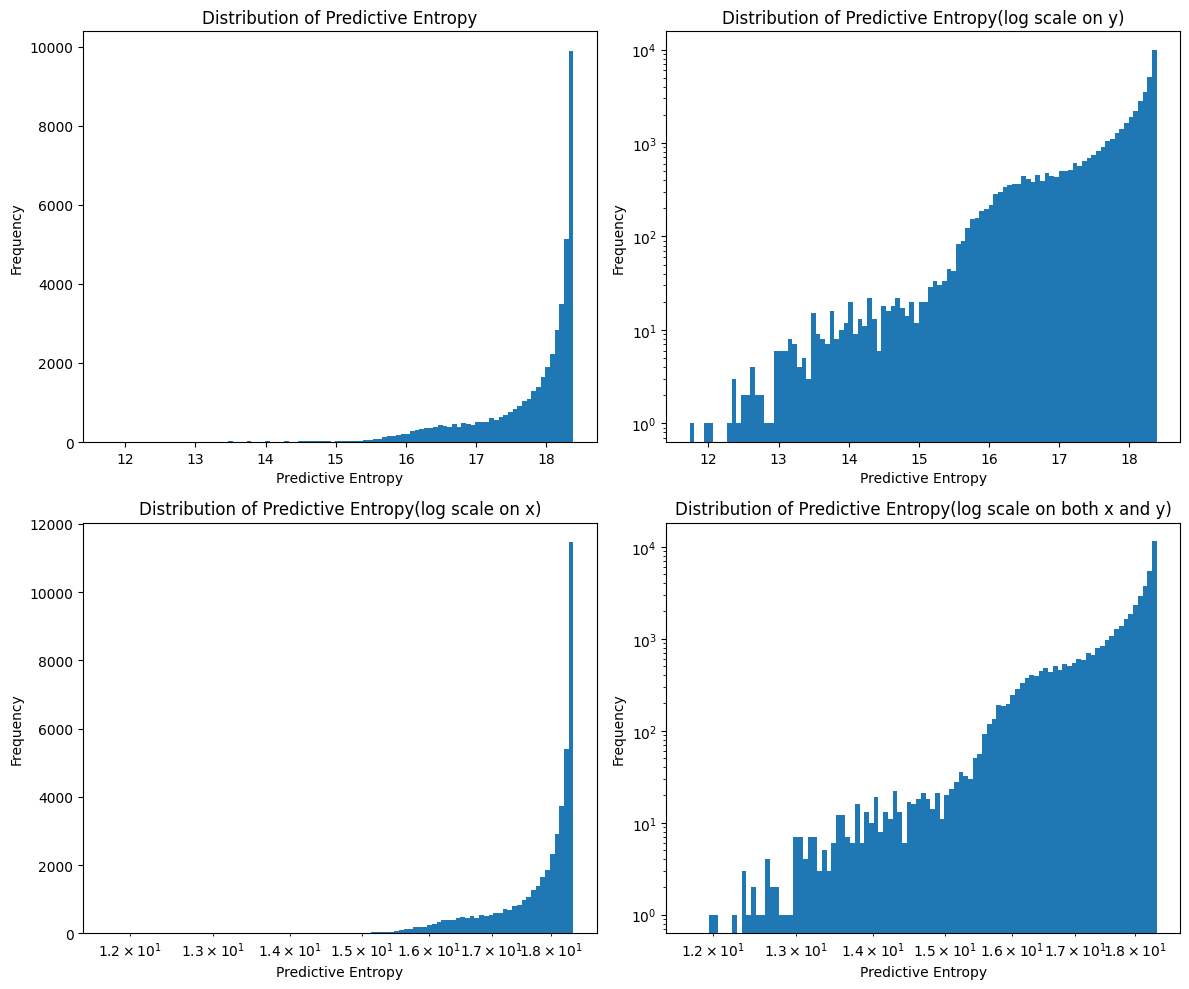

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))

# Analyze entropy distribution
plt.subplot(2, 2, 1)
plt.hist(entropies_predictions, bins=100)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy')

# log scale on y
plt.subplot(2, 2, 2)
plt.xscale('linear')
plt.yscale('log')
plt.hist(entropies_predictions, bins=100)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy(log scale on y)')

# log scale on x
plt.subplot(2, 2, 3)
plt.xscale('log')
bins = np.logspace(np.log10(min(entropies_predictions)), np.log10(max(entropies_predictions)), 100)
plt.hist(entropies_predictions, bins=bins)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy(log scale on x)')

# log scale on both x and y
plt.subplot(2, 2, 4)
plt.xscale('log')
plt.yscale('log')
bins = np.logspace(np.log10(min(entropies_predictions)), np.log10(max(entropies_predictions)), 100)
plt.hist(entropies_predictions, bins=bins)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy(log scale on both x and y)')
plt.tight_layout()
plt.show()



100%|██████████| 30/30 [00:00<00:00, 5866.43it/s]


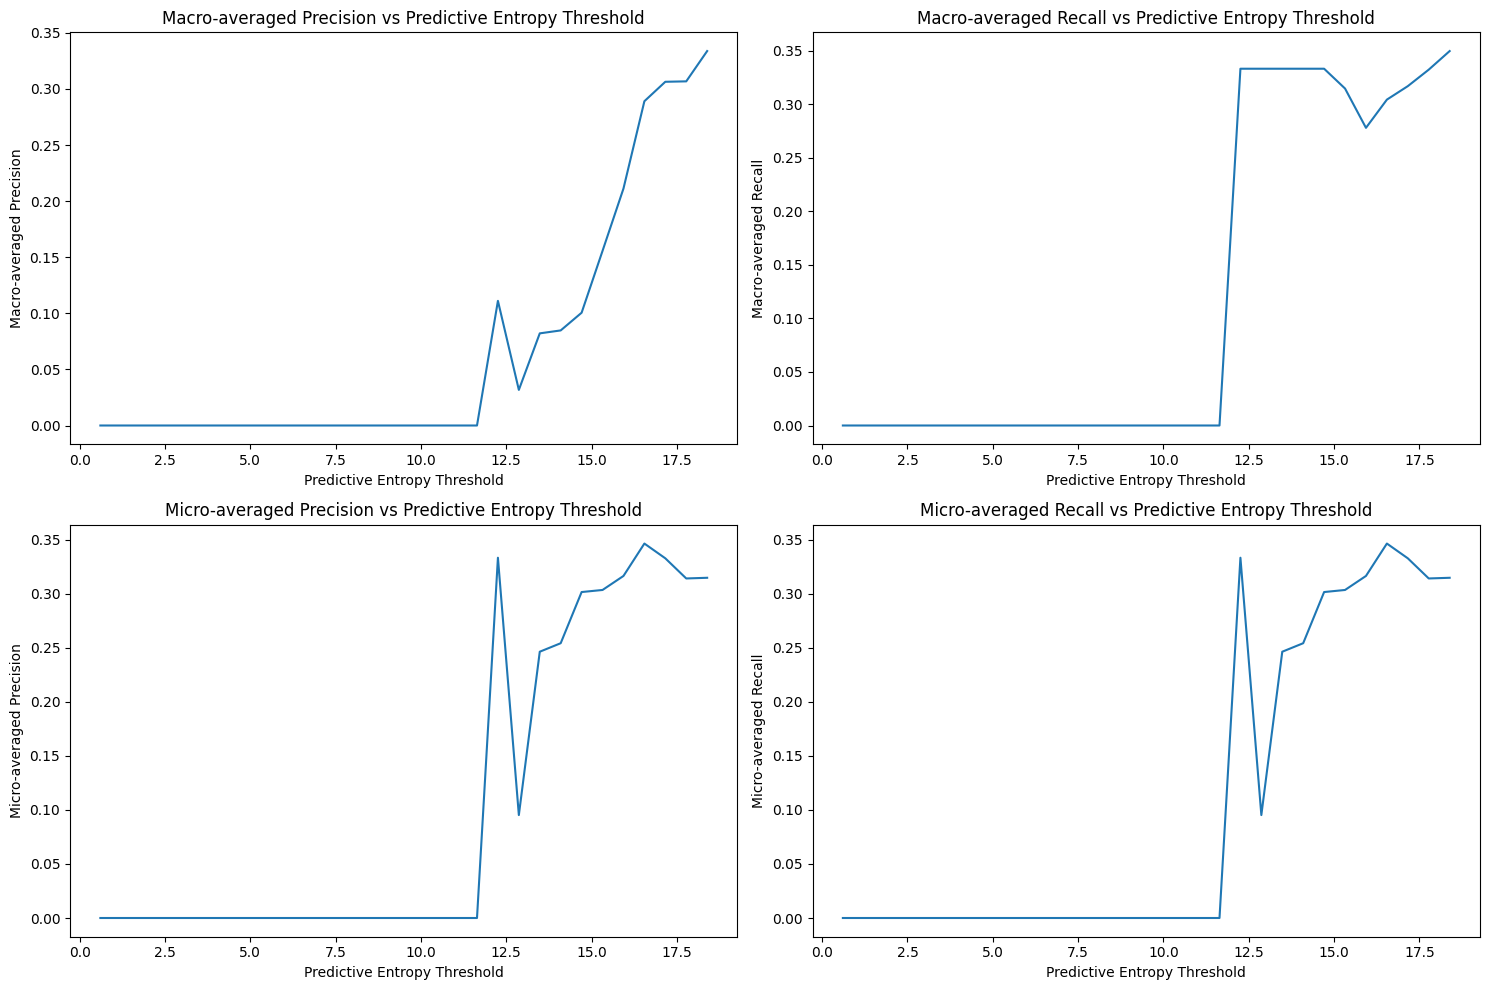

In [ ]:
# Calculate the maximum entropy
max_entropy = np.max(entropies_predictions)
min_entropy = np.min(entropies_predictions)
# Create thresholds from 1/100 of the maximum entropy to the maximum entropy
thresholds = max_entropy * np.linspace(0.033, 1, 30)

# Lists to store macro and micro average precision and recall
macro_precisions = []
macro_recalls = []
micro_precisions = []
micro_recalls = []

predictions = predictions_data.argmax(axis=1)

labels = all_targets
entropies = entropies_predictions
classes = np.unique(labels)  # Get all unique classes (0, 1, 2)


for threshold in tqdm(thresholds):

    confident_mask = entropies <= threshold
    confident_predictions = predictions[confident_mask]
    confident_labels = labels[confident_mask]

    if len(confident_predictions) > 0:
        # For macro-averaging
        precisions_per_class = []
        recalls_per_class = []

        # For micro-averaging
        total_tp = 0
        total_fp = 0
        total_fn = 0

        for class_label in classes:
            # True positives: predicted as class_label and actually is class_label
            true_positives = np.sum((confident_predictions == class_label) &
                                    (confident_labels == class_label))

            # False positives: predicted as class_label but is not class_label
            false_positives = np.sum((confident_predictions == class_label) &
                                     (confident_labels != class_label))

            # False negatives: not predicted as class_label but is class_label
            false_negatives = np.sum((confident_predictions != class_label) &
                                     (confident_labels == class_label))

            # Accumulate for micro-averaging
            total_tp += true_positives
            total_fp += false_positives
            total_fn += false_negatives

            # Calculate precision and recall for this class
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

            precisions_per_class.append(precision)
            recalls_per_class.append(recall)

        # Calculate macro-averaged precision and recall
        macro_precision = np.mean(precisions_per_class)
        macro_recall = np.mean(recalls_per_class)

        # Calculate micro-averaged precision and recall
        micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

        macro_precisions.append(macro_precision)
        macro_recalls.append(macro_recall)
        micro_precisions.append(micro_precision)
        micro_recalls.append(micro_recall)
    else:
        macro_precisions.append(0)
        macro_recalls.append(0)
        micro_precisions.append(0)
        micro_recalls.append(0)
# Plot precision and recall vs entropy thresholds
plt.figure(figsize=(15, 10))

# Plot macro-averaged metrics
plt.subplot(2, 2, 1)
plt.plot(thresholds, macro_precisions)
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Macro-averaged Precision')
plt.title('Macro-averaged Precision vs Predictive Entropy Threshold')

plt.subplot(2, 2, 2)
plt.plot(thresholds, macro_recalls)
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Macro-averaged Recall')
plt.title('Macro-averaged Recall vs Predictive Entropy Threshold')

# Plot micro-averaged metrics
plt.subplot(2, 2, 3)
plt.plot(thresholds, micro_precisions)
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Micro-averaged Precision')
plt.title('Micro-averaged Precision vs Predictive Entropy Threshold')

plt.subplot(2, 2, 4)
plt.plot(thresholds, micro_recalls)
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Micro-averaged Recall')
plt.title('Micro-averaged Recall vs Predictive Entropy Threshold')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

high_predictive_entropy = 30
confident_mask = entropies_predictions <= high_predictive_entropy
confident_predictions = predictions_data[confident_mask].argmax(axis=1)

predictions_critria_0 = 0.45
predictions_critria_2 = 0.45

confident_predictions = np.ones(predictions_data.shape[0])
confident_predictions[predictions_data[:, 0] > predictions_critria_0] = 0
confident_predictions[predictions_data[:, 2] > predictions_critria_2] = 2
confident_labels = all_targets[confident_mask]

print('accuracy_score:', accuracy_score(confident_labels, confident_predictions))
print(classification_report(confident_labels, confident_predictions, digits=4))
conf = confusion_matrix(confident_labels, confident_predictions, normalize='true')
conf_num = confusion_matrix(confident_labels, confident_predictions)
print(conf_num)
print(conf)
print(conf_num[0,0]/(conf_num[0,0] + conf_num[2,0]))
print(conf_num[2,2]/(conf_num[2,2] + conf_num[0,2]))


accuracy_score: 0.40871827383424786
              precision    recall  f1-score   support

         0.0     0.3196    0.3105    0.3150     11274
         1.0     0.4625    0.6512    0.5409     21438
         2.0     0.2683    0.0947    0.1400     13031

    accuracy                         0.4087     45743
   macro avg     0.3501    0.3522    0.3319     45743
weighted avg     0.3719    0.4087    0.3710     45743

[[ 3501  6788   985]
 [ 5096 13961  2381]
 [ 2359  9438  1234]]
[[0.31053752 0.60209331 0.08736917]
 [0.23770874 0.65122679 0.11106446]
 [0.18102985 0.72427289 0.09469726]]
0.5974402730375427
0.5561063542136098
